In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import utils # stuff I've written for this project

import os, sys, datetime, glob, re
import os.path as op

import numpy as np
np.set_printoptions(precision=4)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import shutil

import nibabel as nib

import nilearn
from nilearn.masking import apply_mask
from nilearn.plotting import plot_img, plot_epi, plot_roi, plot_stat_map, view_img, plot_anat
from nilearn.image import load_img, threshold_img, math_img, resample_to_img, new_img_like
from nilearn.input_data import NiftiMasker

import nitime
import nitime.fmri.io as nfio
import nitime.timeseries as ts
import nitime.analysis as nta
import nitime.utils as ntu
import nitime.viz as ntv

import scipy

from bids import BIDSLayout

In [3]:
%matplotlib inline

In [4]:
print(' numpy: ', np.__version__, '\n',
      'nibabel: ', nib.__version__, '\n',
      'nilearn: ', nilearn.__version__, '\n',
      'nitime: ', nitime.__version__, '\n',
      'scipy: ', scipy.__version__)

 numpy:  1.17.5 
 nibabel:  3.1.1 
 nilearn:  0.6.2 
 nitime:  0.8.1 
 scipy:  1.2.1


### Initial definitions (before any preprocessing)

In [5]:
sub = "NB"
ses = "20200929"

raw_data_dir = os.path.abspath("/Users/smerdis/data/LGN/BIDS/NB_20200929/sub-NB/")
raw_layout = BIDSLayout(raw_data_dir, validate=False, derivatives=False)
derivs_dir = os.path.abspath('/Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams')
out_dir = os.path.abspath(f"{derivs_dir}/sub-{sub}")
if not os.path.isdir(out_dir):
    os.makedirs(out_dir)

//anaconda/envs/py37mri/lib/python3.7/site-packages/bids/layout/models.py:102: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  FutureWarning)


### Begin Preprocessing

#### Make ref_vol from first dicom

In [ ]:
first_dicom = "/Users/smerdis/data/LGN/Nb_20200929/Silver_Arjun\ -\ 1/mb_bold_mb3_1p75mm_PSN_5/IM-0005-0001.dcm"
# first_dicom = "/Users/smerdis/data/LGN/Nb_20191221/Silver_Arjun - 1/sb_bold_1p75mmISO_PSN_6/IM-0006-0001.dcm"

In [ ]:
!ls {first_dicom}

In [ ]:
!pwd

In [ ]:
dcm2niix_cmd = f"dcm2niix -v 2 -s y -f {ref_vol_name} -z y -o {out_dir} {first_dicom}"
print(dcm2niix_cmd)
os.system(dcm2niix_cmd)

In [ ]:
!ls {out_dir}

#### make brainmask if it doesn't exist already -- needs work

In [ ]:
masker = NiftiMasker(detrend=False, standardize=False, mask_strategy="epi", t_r=TR)

In [ ]:
ref_bold_run = sorted(preproc_layout.get(subject=sub, session=ses, task="conn", extension=['nii.gz'],
                           run=1, return_type='file'))

In [ ]:
masker.fit(ref_bold_run)

In [ ]:
print(mask_file)

In [ ]:
!ls {mask_file}

In [ ]:
masker.mask_img_.to_filename(mask_file)

In [ ]:
mask_img = masker.mask_img_
mask_img.shape

### Define refence volume

In [6]:
ref_vol_name = f"sub-{sub}_ses-{ses}_refvol"
ref_vol_path = os.path.abspath(f"{out_dir}/{ref_vol_name}.nii.gz")
ref_vol_img = load_img(ref_vol_path)

#### mcflirt the bold files using ref_vol as the reference image, save them as _preproc

In [ ]:
raw_bolds = sorted([f for f in raw_layout.get(subject=sub, session=ses, suffix='bold',
            extension=['nii.gz'], return_type='file')])

In [ ]:
print("\n".join(raw_bolds))

In [ ]:
for this_epi in raw_bolds:
    align_to = 'refvol' #'refvol' # or 'anat'
    epi_name = os.path.basename(this_epi)
    epi_stub = epi_name.split('.')[0]
    epi_stub_parts = epi_stub.split('_')
    epi_stub_parts.insert(-1, 'desc-preproc')
    epi_stub_mcf = '_'.join(epi_stub_parts)
    if not os.path.isdir(os.path.join(out_dir, f"ses-{ses}", "func")):
        os.makedirs(os.path.join(out_dir, f"ses-{ses}", "func"))
    full_outpath = os.path.join(out_dir, f"ses-{ses}", "func", epi_stub_mcf)
    if align_to == 'refvol':
        mcflirt_cmd = f"mcflirt -reffile {ref_vol_path} -mats -plots -report -cost mutualinfo -smooth 16 -in {this_epi} -o {full_outpath}"
    elif align_to == 'anat':
        mcflirt_cmd = f"mcflirt -reffile {anat_file} -mats -plots -report -cost mutualinfo -smooth 16 -in {this_epi} -o {full_outpath}_anatalign"
    print(mcflirt_cmd)
    os.system(mcflirt_cmd)

In [ ]:
!ls /Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB

#### Move event and json files

In [ ]:
events_glob = f"{raw_data_dir}/ses-{ses}/func/*events*.tsv"
print("\n".join(glob.glob(events_glob)))
task_json_glob = f"{raw_data_dir}/ses-{ses}/func/*task*json"
print("\n".join(glob.glob(task_json_glob)))

### Define paths etc

In [7]:
preproc_layout = BIDSLayout(out_dir, validate=False)
# get only the big LGN masks, not any smaller M/P rois already assigned
rois = [f for f in
        preproc_layout.get(subject=sub, extension=['.nii.gz'], suffix='roi', return_type='file')
        if ("desc-LLGN" in f or "desc-RLGN" in f) and ('T1w' not in f)]
big_rois = [f for f in
        preproc_layout.get(subject=sub, extension=['.nii.gz'], suffix='roi', return_type='file')
        if ("desc-LLGN" in f or "desc-RLGN" in f) and ('P' not in f and 'M' not in f and 'T1w' not in f)]
roi_ref_vol = os.path.abspath(f"{out_dir}/sub-{sub}_ses-20191221_refvol.nii.gz")
mask_file = os.path.join(out_dir, f"sub-{sub}_ses-{ses}_mask.nii.gz")
coh_fn = os.path.join(out_dir, f"sub-{sub}_ses-20191221_task-hemi_desc-coherence_map.nii")
anat_file = raw_layout.get(subject=sub, session='20191221', extension=['nii.gz'], suffix="T1w", return_type='file')[0]
anat_img = load_img(anat_file)

print("LGN rois (including M/P):", '\n'.join(rois), "LGN rois (LGN only):", '\n'.join(big_rois), "Reference BOLD volume:", ref_vol_path, "ROI refvol: ", roi_ref_vol, "anat file: ", anat_file, sep="\n")

LGN rois (including M/P):
/Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNsmall_roi.nii.gz
/Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNsmallM80_roi.nii.gz
/Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNsmallP80_roi.nii.gz
/Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGNbig_roi.nii.gz
/Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGNbigM80_roi.nii.gz
/Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGNbigP80_roi.nii.gz
LGN rois (LGN only):
/Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNsmall_roi.nii.gz
/Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-RLGNbig_roi.nii.gz
Reference BOLD volume:
/Users/smerdis

In [ ]:
print(f"fsleyes {anat_file} {ref_vol_path}")

### FLIRT to get everything in the same space

#### flirt first MB3 epi to T1

In [ ]:
print(out_dir)

In [ ]:
bold_to_t1_xfm_path = f"{out_dir}/mb3fmri2t1.mat"
t1_to_bold_xfm_path = f"{out_dir}/t12mb3fmri.mat"

In [ ]:
flirt_cmd = f"flirt -in {ref_vol_path} -ref {anat_file} -omat {bold_to_t1_xfm_path} -out {out_dir}/mb3refvol2t1"
print(flirt_cmd)
os.system(flirt_cmd)

In [ ]:
inverse_cmd = f"convert_xfm -omat {t1_to_bold_xfm_path} -inverse {bold_to_t1_xfm_path}"
os.system(inverse_cmd)

#### flirt ROIs to T1 using reference volume of LGN scan

In [ ]:
!ls {roi_ref_vol}

In [ ]:
roi_to_t1_xfm_path = f"{out_dir}/lgnfmri2t1.mat"
t1_to_roi_xfm_path = f"{out_dir}/t12lgnfmri.mat"

In [ ]:
flirt_cmd = f"flirt -in {roi_ref_vol} -ref {anat_file} -omat {roi_to_t1_xfm_path} -out {out_dir}/lgnfmri2t1"
print(flirt_cmd)
os.system(flirt_cmd)

In [ ]:
inverse_cmd = f"convert_xfm -omat {t1_to_roi_xfm_path} -inverse {roi_to_t1_xfm_path}"
os.system(inverse_cmd)

#### Convert rois to space of structural T1 scan

In [ ]:
## 10/9 - this doesn't appear to work right, but the resampling using nilearn below does

In [ ]:
# for roi in rois:
#     roi_fn_parts = roi.split('_')
#     roi_fn_parts.insert(-1, 'space-T1w')
#     resampled_roi_fn = '_'.join(roi_fn_parts)
#     roi_flirt_cmd = f"flirt -ref {anat_file} -in {roi} -applyxfm -init {roi_to_t1_xfm_path} -out\
#                 {resampled_roi_fn}"
#     print(roi_flirt_cmd)
#     os.system(roi_flirt_cmd)

In [ ]:
print(f"fsleyes {anat_file} {ref_vol_path} {roi_ref_vol}")

#### For testing BIDS names

In [ ]:
utils.isBIDSFile(mask_file)
utils.isBIDSFile(coh_fn)
utils.isBIDSFile(ref_vol_path)
for roi in rois:
    utils.isBIDSFile(roi)

### Write hemifield event files (they are all identical)

In [ ]:
utils.write_hemifield_localizer_event_file(f"{raw_data_dir}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-hemi_run-01_events.tsv")
utils.write_hemifield_localizer_event_file(f"{raw_data_dir}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-hemi_run-02_events.tsv")

In [ ]:
for e in glob.glob(events_glob):
    fileparts = op.split(e)[-1].split('_')[:-1]
    fileparts[0] = f"sub-{sub}"
    #runpart = fileparts[-2]
    #print('_'.join(fileparts), fileparts[-2])
    fn = '_'.join(fileparts)
    new_file_name = f"{raw_data_dir}/ses-{ses}/func/{fn}.tsv"
    print(e, new_file_name, sep="\n")
    #shutil.copyfile(e, new_file_name)

In [ ]:

for e in glob.glob(task_json_glob):
    fn = os.path.split(e)[-1]
    new_file_name = f"{raw_data_dir}/ses-{ses}/func/{fn}"
    print(e, new_file_name, sep="\n")
    #shutil.copyfile(e, new_file_name)

In [ ]:
blocks_in_order = ['L', 'R']
for thisrun in [1]:
    events_fn = f"{raw_data_dir}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-hemi_run-{thisrun:02d}_events.tsv"
    events_file_contents = f"onset\tduration\ttrial_type\n"
    time_between_onsets = 13.5
    for i in range(22):
        events_file_contents += f"{i*time_between_onsets:.2f}\t{time_between_onsets}\t{blocks_in_order[i%(len(blocks_in_order))]}\n"
    #with open(events_fn, 'w') as f:
        #f.write(events_file_contents)
    print(events_fn, '\n', events_file_contents)

## GLM invocation from a cell

### Individual GLMs

Run the GLMs for each task using all runs

In [ ]:
hemi_workdir = utils.run_fixedeffects_glm(sub, ses, "hemi", [1, 2], raw_data_dir, out_dir)

In [ ]:
hemi_datasink = f"{hemi_workdir}/fixedeffects/modelfit/datasink"
print(hemi_workdir, hemi_datasink, sep="\n")
!ls {hemi_datasink}

In [ ]:
mp_workdir = utils.run_fixedeffects_glm(sub, ses, "mp", [1, 2, 3, 4, 5, 6, 7, 8], raw_data_dir, out_dir)

In [ ]:
mp_datasink = f"{mp_workdir}/fixedeffects/modelfit/datasink"
print(mp_workdir, mp_datasink, sep="\n")
!ls {mp_datasink}

In [ ]:
hemi_RL_l1, hemi_RL_l2 = utils.get_model_outputs(hemi_datasink, [1])
hemi_LR_l1, hemi_LR_l2 = utils.get_model_outputs(hemi_datasink, [2])
mp_l1, mp_l2 = utils.get_model_outputs(mp_datasink, [1])
pm_l1, pm_l2 = utils.get_model_outputs(mp_datasink, [2])
visresp_l1, visresp_l2 = utils.get_model_outputs(mp_datasink, [3])

In [ ]:
#print(f"fsleyes {ref_vol_path} {anat_file} {hemi_LR_l2[0]} {hemi_RL_l2[0]} {mp_l2[0]} {pm_l2[0]}")
print(f"fsleyes {ref_vol_path} {anat_file} {hemi_LR_l2[0]} {hemi_RL_l2[0]} {visresp_l2[0]}")

In [ ]:
beta_RL = hemi_RL_l2[0]
beta_LR = hemi_LR_l2[0]
beta_MP = mp_l2[0]
beta_PM = pm_l2[0]
beta_MP_img = load_img(beta_MP)

In [ ]:
beta_RL, beta_MP

### Grab the affine transformation matrix so we can convert EPI to scanner space

In [ ]:
epi_vox_center = (np.array(ref_vol_img.get_fdata().shape) - 1) / 2.
print('epi vox center: ', epi_vox_center)
print(ref_vol_path)

#### resample ROIs

In [ ]:
print(ref_vol_img.shape, ref_vol_img.affine, sep='\n')

In [ ]:
print(out_dir)

In [ ]:
!ls {out_dir}

In [ ]:
resampled_rois = []
for roi in rois:
    roi_img = load_img(roi)
    print(roi_img.shape, roi_img.affine, sep='\n')
    roi_fn_parts = roi.split('_')
    roi_fn_parts.insert(-1, 'space-T1w_nilearn')
    resampled_roi_fn = '_'.join(roi_fn_parts)
    resampled_roi_img = resample_to_img(roi_img, anat_img, 'nearest')
    resampled_roi_img.to_filename(resampled_roi_fn)
    resampled_rois.append(resampled_roi_fn)
    print(resampled_roi_img.shape, resampled_roi_img.affine, sep='\n')
    plot_roi(resampled_roi_img, bg_img=anat_img)

In [ ]:
try:
    if resampled_rois:
        pass
    else:
        resampled_rois = [f for f in
        preproc_layout.get(subject=sub, extension=['.nii.gz'], suffix='roi', return_type='file')
        if ("desc-LLGN" in f or "desc-RLGN" in f) and ('T1w_nilearn' in f)]
except NameError:
    resampled_rois = [f for f in
        preproc_layout.get(subject=sub, extension=['.nii.gz'], suffix='roi', return_type='file')
        if ("desc-LLGN" in f or "desc-RLGN" in f) and ('T1w_nilearn' in f)]
print('\n'.join(resampled_rois))

### Assign 80/20 or whatever

In [ ]:
print(rois)

In [ ]:
print(roi_ref_vol)

In [ ]:
for roi in rois:
    utils.roi_stats({roi:load_img(roi)}, load_img(roi_ref_vol))

In [ ]:
for roi in big_rois:
    big_roi_stub = op.basename(roi).split('_')[-2]
    subdivision_rois = [f for f in rois if big_roi_stub in f and ('P' in f or 'M' in f)]
    utils.roi_centers(roi, subdivision_rois, load_img(roi_ref_vol))

In [ ]:
for roi in resampled_rois:
    utils.roi_stats({roi:load_img(roi)}, anat_img)

In [ ]:
_, mp_l2 = utils.get_model_outputs(mp_datasink, [1])
beta_MP_img = load_img(beta_MP)

In [ ]:
for roi in big_rois:
    roi_stats({roi:load_img(roi)})
    if 'desc-L' in roi:
        M_roi, P_roi, threshold = utils.assign_roi_percentile(roi, beta_MP, 80, ref_vol_img, 'L')
    elif 'desc-R' in roi:
        M_roi, P_roi, threshold = utils.assign_roi_percentile(roi, beta_MP, 80, ref_vol_img, 'R')
    else:
        print('Error - not sure which hemisphere roi is in')
    roi_stats({'M':load_img(M_roi), 'P':load_img(P_roi)})

### Cross-validation

In [ ]:
# add code to:
# compute threshold statistics (variance etc) across xval runs
# 
def cross_val_glm(sub, ses, task, runs, raw_layout, preproc_layout):
    print(raw_layout, preproc_layout, sep="\n")
    raw_data_dir = raw_layout.root
    out_dir = preproc_layout.root
    working_dirs = []
    for i,r in enumerate(runs):
        other_runs = [*runs[0:i], *runs[i+1:]]
        print(i, r, other_runs)
        wdir = utils.run_fixedeffects_glm(sub, ses, task, other_runs,
                    raw_data_dir, out_dir, working_dir_suffix=f"excrun{r}")
        working_dirs.append(wdir)
    return working_dirs

In [ ]:
# beta_imgs = []
# threshold = 6.0
# for workdir in hemi_xval_outputs:
#     datasink = f"{workdir}/fixedeffects/modelfit/datasink"
#     xval_suffix = op.split(workdir)[-1].split('_')[-1] # e.g. 'excrun1'
#     print("xvalRUN", workdir) #, datasink, sep="\n")
#     #!ls {mp_datasink}
#     l1, l2 = utils.get_model_outputs(datasink, [1])
#     beta = l2[0]
#     beta_img = load_img(beta)
#     print(beta, beta_img.shape)
#     #thresholded_beta = threshold_img(beta_img, threshold, copy=True)
#     bin_beta = math_img(f'img > {threshold}', img=beta_img)
#     bin_beta.to_filename(f"{out_dir}/sub-{sub}_ses-{ses}_hemi_mask_{xval_suffix}_thr{threshold:.0f}.nii.gz")
#     #print(np.count_nonzero(thresholded_beta.get_fdata()), np.count_nonzero(bin_beta.get_fdata()))
#     beta_imgs.append(bin_beta)
# print(beta_imgs)
# intersect_img = nilearn.masking.intersect_masks(beta_imgs, threshold=1)
# intersect_img.to_filename(f"{out_dir}/sub-{sub}-ses-{ses}_hemi_intersect_mask_thr{threshold:.0f}.nii.gz")
# print((np.logical_and(*[b.get_fdata() for b in beta_imgs])).to_filename)

In [ ]:
mp_xval_outputs = cross_val_glm(sub, "20191221", "mp", [1, 2, 3, 4, 5, 6, 7, 8], raw_layout, preproc_layout)

In [ ]:
mp_xval_outputs

In [ ]:
plt.imshow(ref_vol_img.get_data()[:,:,13])

In [ ]:
thresholds = np.empty((2, len(mp_xval_outputs)))
for (i, mp_workdir) in enumerate(mp_xval_outputs):
    mp_datasink = f"{mp_workdir}/fixedeffects/modelfit/datasink"
    print("xvalRUN", mp_workdir, mp_datasink, sep="\n")
    #!ls {mp_datasink}
    _, mp_l2 = utils.get_model_outputs(mp_datasink, [1])
    beta_MP = mp_l2[0]
    beta_MP_img = load_img(beta_MP)
    print("Left:")
    LP_roi, LM_roi, Lthreshold = utils.assign_roi_percentile(rois[0], beta_MP, 20, ref_vol_img, 'L')
    thresholds[0, i] = Lthreshold
    print("Right:")
    RP_roi, RM_roi, Rthreshold = utils.assign_roi_percentile(rois[1], beta_MP, 20, ref_vol_img, 'R')
    thresholds[1, i] = Rthreshold
    print("*********\n")

In [ ]:
np.mean(thresholds, axis=1)

In [ ]:
np.std(thresholds, axis=1)

### Viewing and cutting etc

In [ ]:
cut = (-17, -3, 1)

In [ ]:
beta_RL_val = threshold_img(beta_RL, threshold=4.0)

In [ ]:
view_img(beta_RL_val, bg_img=ref_vol_path, cut_coords=cut)

In [ ]:
np.count_nonzero(beta_RL_val.dataobj)

In [ ]:
from nilearn.regions import connected_regions

regions_value_img, index = connected_regions(beta_RL_val,
                                             min_region_size=1500)
title = ("ROIs using image intensity thresholding. "
         "\n Each ROI in same color is an extracted region")
plotting.plot_prob_atlas(regions_value_img, bg_img=ref_vol_path,
                         view_type='auto', display_mode='z',
                         cut_coords=5, title=title)
plotting.show()

## Coherence analysis to identify LGN voxels responding at flicker frequency

### Use the actual utils.py function

In [8]:
hemi_bolds, hemi_masks, hemi_eventfiles, hemi_TR, hemi_confounds = utils.get_files(sub, "20191221", "hemi",
    raw_data_dir, out_dir, run=[1, 2])

Space is None
BOLDS: 2
['/Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/ses-20191221/func/sub-NB_ses-20191221_task-hemi_run-01_desc-preproc_bold.nii.gz', '/Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/ses-20191221/func/sub-NB_ses-20191221_task-hemi_run-02_desc-preproc_bold.nii.gz']
Masks: 2
['/Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/sub-NB_ses-20191221_mask.nii.gz', '/Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/sub-NB_ses-20191221_mask.nii.gz']
Eventfiles: 2
['/Users/smerdis/data/LGN/BIDS/NB_20200929/sub-NB/ses-20191221/func/sub-NB_ses-20191221_task-hemi_run-01_events.tsv', '/Users/smerdis/data/LGN/BIDS/NB_20200929/sub-NB/ses-20191221/func/sub-NB_ses-20191221_task-hemi_run-02_events.tsv']
[2.25, 2.25] 2
Confounds: 0
[]


### Define hemifield alternation time series etc

0.037037037037037035
[  0.     2.25   4.5    6.75   9.    11.25  13.5   15.75  18.    20.25
  22.5   24.75  27.    29.25  31.5   33.75  36.    38.25  40.5   42.75
  45.    47.25  49.5   51.75  54.    56.25  58.5   60.75  63.    65.25
  67.5   69.75  72.    74.25  76.5   78.75  81.    83.25  85.5   87.75
  90.    92.25  94.5   96.75  99.   101.25 103.5  105.75 108.   110.25
 112.5  114.75 117.   119.25 121.5  123.75 126.   128.25 130.5  132.75
 135.   137.25 139.5  141.75 144.   146.25 148.5  150.75 153.   155.25
 157.5  159.75 162.   164.25 166.5  168.75 171.   173.25 175.5  177.75
 180.   182.25 184.5  186.75 189.   191.25 193.5  195.75 198.   200.25
 202.5  204.75 207.   209.25 211.5  213.75 216.   218.25 220.5  222.75
 225.   227.25 229.5  231.75 234.   236.25 238.5  240.75 243.   245.25
 247.5  249.75 252.   254.25 256.5  258.75 261.   263.25 265.5  267.75
 270.   272.25 274.5  276.75 279.   281.25 283.5  285.75 288.   290.25
 292.5  294.75 297.   299.25 301.5  303.75 306.   308.25

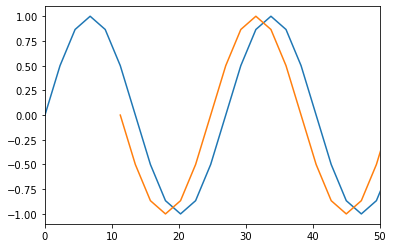

In [9]:
cycle_duration = 27 # (should be 27s)
hemi_freq = (1.0/cycle_duration) # of hemifield alternation, in hertz
n_trs_func = 139 # Length, in TRs, on a functional scan
total_len = n_trs_func*hemi_TR # seconds
Fs = 1/hemi_TR # Sampling freq
trs_exc_beg = 6
trs_exc_end = 1
nperseg = n_trs_func - trs_exc_beg - trs_exc_end

f_lb = 0.02
f_ub = 0.15

print(hemi_freq)

t = np.arange(0.0, total_len, hemi_TR)
t_trim = np.arange((trs_exc_beg-1)*hemi_TR, (total_len - trs_exc_beg - trs_exc_end)+1, hemi_TR)
hemifield_alternation_sinusoid = np.sin(hemi_freq*2*np.pi*t)
hemi_alt_trim = hemifield_alternation_sinusoid[trs_exc_beg:(-1*trs_exc_end)]
print(t, hemifield_alternation_sinusoid.shape)

hemi_ts = ts.TimeSeries(data=hemifield_alternation_sinusoid,
                         sampling_interval=hemi_TR)
hemi_ts_trim = ts.TimeSeries(data=hemi_alt_trim,
                         sampling_interval=hemi_TR)

fig, ax = plt.subplots(1)
ax.set_xlim(0, 50)
ax.plot(t, hemifield_alternation_sinusoid)
ax.plot(t_trim, hemi_alt_trim)

In [10]:
lgn_masker, lgn_ts_run1 = utils.get_timeseries_from_file(hemi_bolds[0], rois[0], hemi_TR,
                                detrend=False, standardize=False, high_pass=f_lb, low_pass=f_ub)

(139,) (78, 139) (78, 33) (33,) (19,)


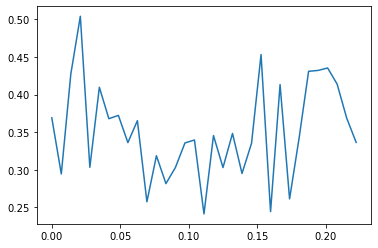

In [24]:
hemi_analyzer, hemi_coh_by_voxel = utils.seed_coherence_timeseries(hemi_ts, lgn_ts_run1, f_ub, f_lb, dict(NFFT=64))

(139,) (78, 139) (78, 33) (33,) (19,)


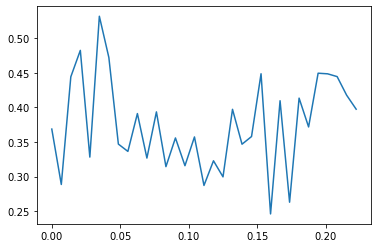

In [25]:
_, lgn_ts_run2 = utils.get_timeseries_from_file(hemi_bolds[1], rois[0], hemi_TR,
                                detrend=False, standardize=False, high_pass=f_lb, low_pass=f_ub)
hemi_analyzer, hemi_coh_by_voxel = utils.seed_coherence_timeseries(hemi_ts, lgn_ts_run2, f_ub, f_lb, dict(NFFT=64))

#### Write coherence values to Nifti file

In [ ]:
coherence_img = lgn_masker.inverse_transform(hemi_coh_by_voxel)
coherence_img.shape

In [ ]:
print(coh_fn)

In [ ]:
coherence_img.to_filename(coh_fn)

#### average the runs

In [26]:
mean_bold_timeseries = utils.average_timeseries(hemi_bolds, lgn_masker)

0
(139, 78, 2)
(139, 78)
float32
[[  0.1664   0.172    0.4573  -0.101    0.1509]
 [-12.476    4.3216  27.8653   4.1132  20.3516]
 [-31.3462   8.7539 -22.096   -1.6163  15.9776]
 [-17.2473  27.9383 -46.175   11.6815  -5.0467]
 [ -0.4476  27.9393   6.186   28.3341   2.8093]]
1
(139, 78, 2)
(139, 78)
float32
[[-6.9240e-02  2.5651e-01  1.0309e-01  4.9120e-02  4.2155e-02]
 [-4.3330e+01 -2.0524e+01 -1.6374e+01  3.7353e+00 -1.3244e+01]
 [-5.8057e+00  6.2590e-02 -1.9373e+01  1.1098e+01 -2.1090e+01]
 [ 1.4603e+01  1.7248e+01 -6.9593e+00  1.8850e+01 -5.8685e+00]
 [-2.3737e+01 -1.2156e+00 -7.0719e+00  1.0046e+01  1.0072e+01]]


In [27]:
mean_bold_timeseries.shape

(139, 78)

In [28]:
trim_bold_nm = mean_bold_timeseries[trs_exc_beg:(-1*trs_exc_end),:] # note we are using the mean of the two runs
trim_bold_nm.shape

(132, 78)

(132,) (78, 132) (78, 17) (17,) (9,)


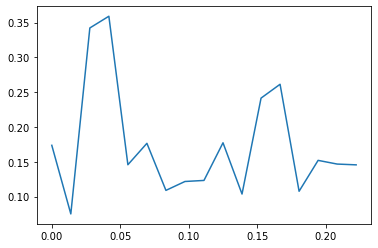

In [36]:
mean_lgn_ts = ts.TimeSeries(data=trim_bold_nm.T, sampling_interval=hemi_TR)
hemi_analyzer, hemi_coh_by_voxel = utils.seed_coherence_timeseries(hemi_ts_trim, mean_lgn_ts, f_ub, f_lb, dict(NFFT=32))

#### SpectralAnalyzer

In [ ]:
assert(nperseg == mean_lgn_ts.shape[-1])

In [ ]:
S_original = nta.SpectralAnalyzer(mean_lgn_ts, method={'this_method':'welch', 'NFFT':nperseg, 'Fs':mean_lgn_ts.sampling_rate})

In [ ]:
print(S_original)

In [ ]:
def plot_spectra(S_original, voxid):
    fig01 = plt.figure()
    ax01 = fig01.add_subplot(1, 1, 1)
    ax01.plot(S_original.psd[0],
              S_original.psd[1][voxid],
              label='Welch PSD')
    print(S_original.psd[0], S_original.psd[1], len(S_original.psd[1]))

    ax01.plot(S_original.spectrum_fourier[0],
              np.abs(S_original.spectrum_fourier[1][voxid]),
              label='FFT')
    
    ax01.set_xlabel('Frequency (Hz)')
    ax01.set_ylabel('Power')

    ax01.legend()

In [ ]:
voxid = 65

In [ ]:
plot_spectra(S_original, voxid)

In [ ]:
def comparison_plots(masked_ts_flat, S_original, Fs, nperseg, voxid=1000):
    # Compute PSD with `scipy.signal.welch`
    f_welch, S_welch = scipy.signal.welch(
        masked_ts_flat[voxid, :], fs=Fs, nperseg=nperseg, noverlap=(nperseg // 2),
        detrend=None, scaling='density', window='hanning')

    # Compute PSD with `matplotlib.mlab.psd`, using parameters that are
    # *equivalent* to those used in `scipy.signal.welch` above
    S_mlab, f_mlab = mlab.psd(
        masked_ts_flat[voxid, :], Fs=Fs, NFFT=nperseg, noverlap=(nperseg // 2),
        detrend=None, scale_by_freq=True, window=mlab.window_hanning)

    fig, axes = plt.subplots(3, 1, sharex=True)

    # Plot PSD computed via both methods
    axes[0].plot(f_welch, S_welch, label='scipy.signal.welch')
    axes[0].plot(f_mlab, S_mlab, label='mlab.psd')
    axes[0].set_ylabel('PSD')
    axes[0].legend()

    axes[1].plot(S_original.spectrum_fourier[0],
                  np.abs(S_original.spectrum_fourier[1][voxid]),
                  label='nitime FFT')

    freqs2 = nitime.utils.get_freqs(Fs, masked_ts_flat.shape[-1])
    fft = scipy.fftpack.fft(masked_ts_flat.data)
    scaledAmp = np.abs(fft[:, :freqs2.shape[0]])
    amp = 2*scaledAmp/masked_ts_flat.shape[-1]
    sqrtsummagsq = np.sqrt(np.sum(scaledAmp[:, :]**2))
    print(sqrtsummagsq)
    co = scaledAmp[:,11]/sqrtsummagsq;

    axes[1].plot(freqs2, scaledAmp[voxid], label='ScaledAmp')
    axes[2].plot(freqs2, amp[voxid], label='Amp')
    axes[2].set_xlabel('f')
    axes[1].legend()
    axes[2].legend()

    plt.suptitle(f"voxid {voxid}, co {co[voxid]}")
    plt.show()
    
    return [freqs2, amp, co]

In [ ]:
Fs

In [ ]:
for v in range(10, 11):
    _ = comparison_plots(trim_bold_nm.T, S_original, Fs, nperseg, v)

In [ ]:
[f, a, co] = comparison_plots(masked_ts_flat, S_original, Fs, nperseg, 1000)

In [ ]:
plt.hist(co)

In [ ]:
coh_amp_map = masker.inverse_transform(co)

In [ ]:
coh_amp_map.to_filename(coh_fn)

### SeedCoherenceAnalyzer for connectivity

In [18]:
conn_bolds, conn_masks, conn_eventfiles, conn_TR, conn_confounds = utils.get_files(sub, ses, "conn",
    raw_data_dir, out_dir, run=[1, 5,])

//anaconda/envs/py37mri/lib/python3.7/site-packages/bids/layout/models.py:102: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  FutureWarning)


Space is None
BOLDS: 2
['/Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/ses-20200929/func/sub-NB_ses-20200929_task-conn_run-01_desc-preproc_bold.nii.gz', '/Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/ses-20200929/func/sub-NB_ses-20200929_task-conn_run-05_desc-preproc_bold.nii.gz']
Masks: 2
['/Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/sub-NB_ses-20200929_mask.nii.gz', '/Users/smerdis/data/LGN/BIDS/NB_20200929/derivatives/streams/sub-NB/sub-NB_ses-20200929_mask.nii.gz']
Eventfiles: 0
[]
[2.25, 2.25] 2
Confounds: 0
[]
Some functional runs do not have corresponding event files!


In [19]:
f_lb = 0.02
f_ub = 0.15

In [20]:
conn_coh_fn = os.path.join(out_dir, f"sub-{sub}_ses-{ses}_task-conn_desc-coherence_map.nii")

//anaconda/envs/py37mri/lib/python3.7/site-packages/nilearn/image/resampling.py:513: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


(128,) (278079, 128) (278079, 17) (17,) (9,)


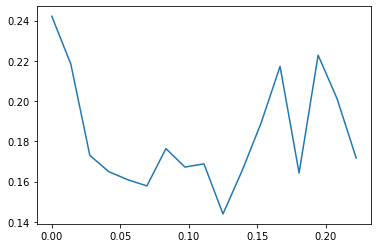

In [23]:
a = utils.seed_coherence_analysis(conn_bolds[0], conn_masks[0], rois[0],
                                  conn_TR, f_ub, f_lb, conn_coh_fn, mean_seed=True)

## Assigning voxels within an ROI to M/P

In [ ]:
LP_roi, LM_roi = utils.assign_roi_percentile(rois[0], beta_MP, 20)

In [ ]:
RP_roi, RM_roi = utils.assign_roi_percentile(rois[1], beta_MP, 20)

## ROI plotting

In [ ]:
imgs_in_order = [RP_roi, RM_roi, beta_MP_img]
r = 5
c = 3
fig, ax = plt.subplots(nrows=r, figsize=(10,10))
img_data = [img.get_data() for img in imgs_in_order]
p_roi, m_roi, beta_mp = img_data
print([np.count_nonzero(x) for x in img_data])
p_roi_masked = np.ma.masked_where(p_roi==0, p_roi)
m_roi_masked = np.ma.masked_where(m_roi==0, m_roi)
p_mask = np.ma.getmask(p_roi_masked)
m_mask = np.ma.getmask(m_roi_masked)
both_mask = np.logical_and(p_mask,m_mask)
beta_masked = np.ma.masked_array(beta_mp, mask=both_mask)
print([np.count_nonzero(~m) for m in [p_mask, m_mask, both_mask]])
ref_vol_data = ref_vol_img.get_data()
for ri in range(r):
    #ax[ri].imshow(ref_vol_data[10:64,50:70,14-ri])
    pos = ax[ri].imshow(beta_masked[40:64,50:70,14-ri], cmap="cyan_orange")
    plt.colorbar(pos, ax=ax[ri])

In [ ]:
imgs_in_order = [LP_roi, LM_roi]
r = 5
c = 2
fig, ax = plt.subplots(nrows=r, ncols=c, figsize=(10,10))
img_data = [img.get_data() for img in imgs_in_order]
img_data_masked = [np.ma.masked_where(img==0, img) for img in img_data]
ref_vol_data = ref_vol_img.get_data()
    #plot_roi(imgdata[slice(70,80), slice(55,65), slice(10,15)])
for ri in range(r):
    for ci in range(c):
        ax[ri, ci].imshow(ref_vol_data[64:-20,:,14-ri])
        ax[ri, ci].imshow(img_data_masked[ci][64:-20,:,14-ri], cmap="binary")

In [ ]:
imgs_in_order=[RP_roi, RM_roi]
r = 5
c = 2
fig, ax = plt.subplots(nrows=r, ncols=c, figsize=(10,10))
img_data = [img.get_data() for img in imgs_in_order]
img_data_masked = [np.ma.masked_where(img==0, img) for img in img_data]
ref_vol_data = ref_vol_img.get_data()
    #plot_roi(imgdata[slice(70,80), slice(55,65), slice(10,15)])
for ri in range(r):
    for ci in range(c):
        ax[ri, ci].imshow(ref_vol_data[10:64,:,14-ri])
        ax[ri, ci].imshow(img_data_masked[ci][10:64,:,14-ri], cmap="binary")

In [ ]:
def view_copes(datasink, contrasts, **kwargs):
    l1copes, l2copes = utils.get_model_outputs(datasink, contrasts)
    return nilearn.plotting.view_img(l2copes[0], **kwargs)

In [ ]:
view_copes(mp_datasink, [3], bg_img=ref_vol_path, threshold="90%", vmax=3, cut_coords=cut)

In [ ]:
def plot_lgn(datasink, contrasts, **kwargs):
    l1copes, l2copes = utils.get_model_outputs(datasink, contrasts)
    return nilearn.plotting.plot_img(l2copes[0], **kwargs)

In [ ]:
plot_lgn(mp_datasink, [3], threshold=2, cut_coords=cut, bg_img=ref_vol_path)

In [ ]:
view_copes(hemi_datasink, [3], bg_img=ref_vol_path, threshold=2, vmax=5, cut_coords=(-17, -3, 1))

In [ ]:
LP_roi.get_data().shape

In [ ]:
roi_fig = plt.figure(figsize=(10, 5))
plot_roi(LP_roi, bg_img=ref_vol_path, display_mode='x',
         cut_coords=range(-23, -14), cmap=plt.get_cmap("brown_cyan"),
        figure=roi_fig)
roi_fig2 = plt.figure(figsize=(10, 5))
plot_roi(LP_roi, bg_img=anat_file, display_mode='x',
         cut_coords=range(-23, -14), cmap=plt.get_cmap("brown_cyan"),
        figure=roi_fig2)

In [ ]:
plot_roi(LP_roi, bg_img=ref_vol_path, cut_coords=cut)